In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv
import time

# Building Knowledge Graph

## Extract Data from CSV

In [2]:
def get_csv_data(filepath, handle_row_func):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        for row in rows:
            handle_row_func(data, row)
    return data

In [3]:
def handle_csv_kanji_func(data, row):
    kanji,*meanings = row
    if len(meanings) >= 2:
        meanings = ",".join(meanings)
    else:
        meanings = meanings[0]
    meanings = meanings.split(":")
    meanings = meanings[0]
    data[kanji] = meanings

In [4]:
data_kanji = get_csv_data("dataset/s5_kanjis_output.csv", handle_csv_kanji_func)
print("len(data_kanji) = ", len(data_kanji))
# pp(data_kanji)

len(data_kanji) =  6215


In [5]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row
    data[radical] = meaning

In [6]:
data_radical = get_csv_data("dataset/s7_nodes_radical_meaning.csv", handle_csv_radical_func)
print("len(data_radical) = ", len(data_radical))
# pp(data_radical)

len(data_radical) =  255


In [7]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    data[kanji] = radical_list.split(':')

In [8]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
# pp(data_edges)

len(data_edges) =  6215


## Data Structure

### Node Manager

In [9]:
def get_key(symbol, dtype):
    return f"{symbol}-{dtype}"

In [10]:
node_kanji = {
    get_key(symbol, 'kanji'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'red',
    } for symbol, meaning in data_kanji.items()}

In [11]:
node_radical = {
    get_key(symbol, 'radical'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'yellow',
    } for symbol, meaning in data_radical.items()}

In [12]:
full_node = {**node_radical, **node_kanji}
# pp(list(full_node.keys()))

### Edge Manager

In [13]:
def get_graph_edge(data_edges):
    edges = []
    for kanji, radicals in data_edges.items():
        for r in radicals:
            edges.append( (f"{kanji}-kanji", f"{r}-radical") )
    return edges

full_edges = get_graph_edge(data_edges)
# full_edges

## Kanji Graph

In [14]:
import networkx as nx

In [15]:
kjg = nx.Graph()

kjg.add_nodes_from(full_node.items())
kjg.add_edges_from(full_edges)

### Graph Visualization

In [16]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [17]:
def visualize_graph(
    Graph: nx.Graph, 
    figsize: tuple=(7,7), 
    color_map: List[str]=None, 
    node_size: int=3000, 
    with_labels: bool=True) -> None:
    
    if color_map == None:
        color_map = [Graph.nodes[n]["color"] for n in Graph] 
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    
    labels = nx.get_node_attributes(Graph, 'visual')
    
    nx.draw_kamada_kawai(Graph, 
                         node_color=color_map, 
                         with_labels=with_labels,
                         labels=labels,
                         node_size=node_size, 
                         font_size=20,
                         font_family="Noto Serif CJK JP")
    plt.show()

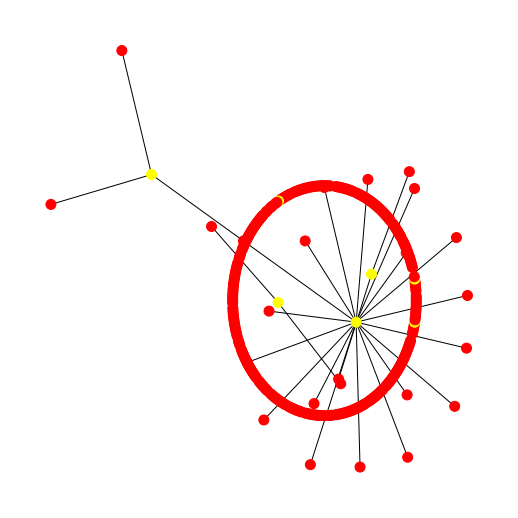

In [18]:
visualize_graph(
    Graph       = kjg.subgraph(random.sample(kjg.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

In [19]:
def get_sg_kanji_with(kjg) -> nx.Graph:
    sg = nx.Graph()
    p = '痘-kanji'
    radicals = [n for n in kjg.neighbors(p)]
    sg.add_nodes_from([(p, kjg.nodes[p])] + [(r, kjg.nodes[r]) for r in radicals])
    sg.add_edges_from([(p, rp) for rp in radicals])
    return sg

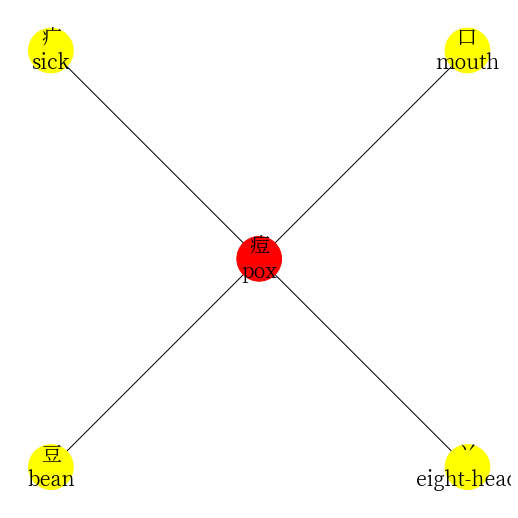

In [20]:
visualize_graph(
    Graph       = get_sg_kanji_with(kjg),
    node_size   = 2000,
    with_labels = True,
)

### Exploratory Data Analysis

In [21]:
print(nx.info(kjg))

Graph with 6470 nodes and 22273 edges


In [22]:
# https://networkx.org/documentation/stable/reference/algorithms/component.html

print('number of connected components: ', nx.number_connected_components(kjg))

number of connected components:  10


In [23]:
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

print('number of isolated: ', nx.number_of_isolates(kjg))
isolated_nodes = [n for n in nx.isolates(kjg)]
pp(isolated_nodes)
kjg.remove_nodes_from(list(nx.isolates(kjg)))

number of isolated:  9
['匸-radical',
 '夊-radical',
 '艸-radical',
 '辵-radical',
 '邑-radical',
 '阜-radical',
 '鬯-radical',
 '鼎-radical',
 '龍-radical']


In [24]:
print(nx.info(kjg))

print('number of connected components: ', nx.number_connected_components(kjg))

Graph with 6461 nodes and 22273 edges
number of connected components:  1


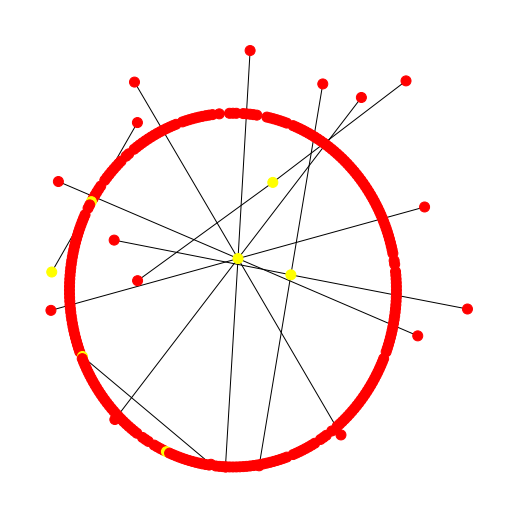

In [25]:
visualize_graph(
    Graph       = kjg.subgraph(random.sample(kjg.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

# Querying Knowledge Graph

## Data Structure

In [26]:
def generate_graph(G: nx.Graph, nodes: List) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from([(n, G.nodes[n]) for n in nodes])
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [27]:
def get_node_color_result(kinputs, koutputs, union_result):
    G = union_result
    color_map = []
    for n in union_result:
        if n in kinputs:
            color_map.append("green")
        elif n in koutputs:
            color_map.append("blue")
        else:
            color_map.append(G.nodes[n]["color"])
    return color_map

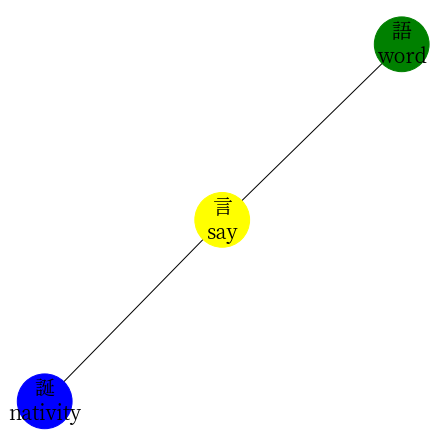

In [28]:
kin = '語-kanji'  # say
kout = '誕-kanji' # lie 

result_shortest_path = nx.shortest_path(G=kjg, source=kin, target=kout)
result = generate_graph(kjg, result_shortest_path)

visualize_graph(
    Graph=result, 
    color_map=get_node_color_result([kin], [kout], result), 
    figsize=(6,6)
)

## Algorithm

### Brute Force Algorithm

In [29]:
def find_path_bf(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

### Astar Algorithm

In [30]:
def find_path_astar(G: nx.Graph, MOrig: List, MDest: List, heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            sp_graph = generate_graph(G, sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

#### Heuristic

In [31]:
# all_pairs_common_neighbors = dict()
# for u in kjg:
#     print("u", u)
#     if u not in all_pairs_common_neighbors:
#         all_pairs_common_neighbors[u] = dict()
#     for v in kjg:
#         print("v", v)
#         all_pairs_common_neighbors[u][v] = nx.common_neighbors(kjg, u, v)

In [32]:
# all_pairs_common_neighbors

In [33]:
def common_neighbor(u, v):
    G = kjg
    return len(list(nx.common_neighbors(G, u, v)))

In [34]:
def jaccard_function(u, v):
    G = kjg
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return len(list(nx.common_neighbors(G, u, v))) / union_size

### Steiner Tree

In [35]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    # check for connected graph while processing first node
    all_paths_iter = nx.all_pairs_dijkstra(G, weight='weight')
    u, (distance, path) = next(all_paths_iter)
    if Gnodes - set(distance):
        msg = "G is not a connected graph. metric_closure is not defined."
        raise nx.NetworkXError(msg)
    Gnodes.remove(u)
    for v in Gnodes:
        M.add_edge(u, v, distance=distance[v], path=path[v])

    # first node done -- now process the rest
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [36]:
def steiner_tree(G, terminal_nodes, weight="weight"):
    # H is the subgraph induced by terminal_nodes in the metric closure M of G.
    M = metric_closure(G, weight=weight)
    H = M.subgraph(terminal_nodes)
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True)
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    # For multigraph we should add the minimal weight edge keys
    if G.is_multigraph():
        edges = (
            (u, v, min(G[u][v], key=lambda k: G[u][v][k][weight])) for u, v in edges
        )
    T = G.edge_subgraph(edges)
    return T

In [37]:
def find_path_steiner(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    return nx.steiner_tree(G, MOrig + MDest)     

# Experiment

## Test Case

In [38]:
from kanji_lists import JLPT, KYOIKU
# https://github.com/ffe4/kanji-lists

In [39]:
test_cases_raw = {
    'N5 to N4': {
        'MOrig': JLPT.N5,
        'MDest': JLPT.N4,
    },
    'N4 to N3': {
        'MOrig': JLPT.N4,
        'MDest': JLPT.N3,
    },
    'N3 to N2': {
        'MOrig': JLPT.N3,
        'MDest': JLPT.N2,
    },
    'N2 to N1': {
        'MOrig': JLPT.N2,
        'MDest': JLPT.N1,
    },
    'G1 to G2': {
        'MOrig': KYOIKU.GRADE1,
        'MDest': KYOIKU.GRADE2,
    },
    'G2 to G3': {
        'MOrig': KYOIKU.GRADE2,
        'MDest': KYOIKU.GRADE3,
    },
    'G3 to G4': {
        'MOrig': KYOIKU.GRADE3,
        'MDest': KYOIKU.GRADE4,
    },
    'G4 to G5': {
        'MOrig': KYOIKU.GRADE4,
        'MDest': KYOIKU.GRADE5,
    },
    'G5 to G6': {
        'MOrig': KYOIKU.GRADE5,
        'MDest': KYOIKU.GRADE6,
    },
}

In [40]:
def tc_filter_in_graph(G, kanji_list):
    
    tc_filtered = []
    for k in kanji_list:

        tk = get_key(k, 'kanji')
        
        if tk in G:
            tc_filtered.append(tk)
            continue
        
        tr = get_key(k, 'radical')
        if tr in G:
            tc_filtered.append(tr)
            continue
            
    return tc_filtered

In [41]:
def filter_test_cases_raw(G, test_cases_raw):
    test_cases_clean = {}
    for tc_name, tc in test_cases_raw.items():

        MOrig = tc_filter_in_graph(G, tc['MOrig'])
        MDest = tc_filter_in_graph(G, tc['MDest'])

        test_cases_clean[tc_name] = {
            'MOrig': MOrig,
            'MDest': MDest,
        }

    return test_cases_clean

In [42]:
test_cases_clean = filter_test_cases_raw(kjg, test_cases_raw)

In [43]:
def find_path(G: nx.Graph, MOrig: List, MDest: List, method='brute_force') -> nx.Graph:
    if method == 'brute_force':
        return find_path_bf(G, MOrig, MDest)
    elif method == 'steiner_tree':
        return find_path_steiner(G, MOrig, MDest)
    elif method == 'astar_common_neighbor':
        return find_path_astar(G, MOrig, MDest, common_neighbor)
    elif method == 'astar_jaccard':
        return find_path_astar(G, MOrig, MDest, jaccard_function)
    elif method == 'astar_0':
        return find_path_astar(G, MOrig, MDest, lambda x, y: 0)
    else:
        raise ValueError(f"method {method} is not valid")

## Testing

In [44]:
def get_result_accuracy(G0, Gt):
    common_nodes = len(G0.nodes() & Gt.nodes())
    G0_nodes     = len(G0.nodes())
    
    return common_nodes / G0_nodes

In [45]:
def get_results_kanjigen(G: nx.Graph, test_cases_clean: dict, algo_list: List):
    results = {tc_name: dict() for tc_name in test_cases_clean}

    for tc_name, tc in test_cases_clean.items():
        
        if tc_name != 'N5 to N4':
            continue
        
        MOrig = tc['MOrig']
        MDest = tc['MDest']
        
        # get time
        for algo in algo_list:
            
            print(f"algo: {algo}")
            print(f"tc: {tc_name} of {len(test_cases_clean)}")
            start  = time.time()
            graph  = find_path(G, MOrig, MDest, algo)
            end    = time.time()
            print("finish")
            print("==============")
            
            results[tc_name][algo] = {'graph': graph, 'time': (end - start)}
        
        # get accuracy
        
        G0 = results[tc_name]['brute_force']['graph']
        results[tc_name]['brute_force']['accuracy'] = 1.0
        for algo in [algo for algo in algo_list if algo != 'brute_force']:
            
            Gt = results[tc_name][algo]['graph']
            
            results[tc_name][algo]["accuracy"] = get_result_accuracy(G0, Gt)
    
    return results

In [ ]:
algo_list = ['brute_force', 'astar_common_neighbor', 'astar_jaccard', 'astar_0']
results = get_results_kanjigen(kjg, test_cases_clean, algo_list)

algo: brute_force
tc: N5 to N4 of 9
finish
algo: astar_common_neighbor
tc: N5 to N4 of 9


In [ ]:
pp(results)

# Analysis

In [ ]:
def get_df_results(results, algo_list):
    df_results = {algo: dict() for algo in algo_list}
    for tc_name, res in results.items():
        
        
        for algo in algo_list:
            if algo not in res:
                continue
            
            if tc_name not in df_results[algo]:
                df_results[algo][tc_name] = dict()
                
            
            df_results[algo][tc_name]['accuracy'] = round(res[algo]['accuracy'], 2)
            df_results[algo][tc_name]['time']     = round(res[algo]['time'], 2)
    return df_results

In [ ]:
df_results = get_df_results(results, algo_list)
df_results

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame(df_results)

In [ ]:
df